# Fit Demo -- Simulated AGN
---------------------------
Simulate data with the AGN module included, fit it, and see how close to the input parameters we
get.

## Imports

In [9]:
import numpy as np
import astropy.units as u
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior

## Initialize Lightning

In [2]:
filter_labels = ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z',
                 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4',
                 'MIPS_CH1',
                 'PACS_green', 'PACS_red']

# Redshift 0, default stellar age bins
l = Lightning(filter_labels, 
              lum_dist=10.0, # Mpc
              SFH_type='Piecewise-Constant',
              atten_type='Modified-Calzetti',
              dust_emission=True,
              agn_emission=True,
              print_setup_time=True)

0.018 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.718 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.277 s elapsed in dust emission model setup
0.036 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
1.050 s elapsed total


/Users/Erik/Research/code/plightning/lightning/get_filters.py:143: RuntimeWarning: divide by zero encountered in divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)
/Users/Erik/Research/code/plightning/lightning/get_filters.py:143: RuntimeWarning: invalid value encountered in divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


## Fake some data

In [3]:
params = np.array([1,1,1,1,1,
                   0.3, 0.0, 0.0,
                   2, 1, 3e5, 0.1, 0.01,
                   11, 0.5, 7])

Lmod, _ = l.get_model_lnu(params)

snr = 10.0

rng = np.random.default_rng()

Lsim = rng.normal(loc=Lmod, scale=Lmod / snr)
Lsim_unc = Lsim / snr

# A silly step, converting the data to mJy just so lightning can convert back to Lsun Hz-1
DL = 10 * u.Mpc

fsim = (Lsim * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value
fsim_unc = (Lsim_unc  * u.Lsun / u.Hz / (4 * np.pi * DL**2)).to(u.mJy).value

# Note the warning generated by this step -- the minimum luminosity distance is probably something
# we ought to change; we'll want to add the option to specify a luminosity distance rather than
# a redshift for very nearby galaxies.
l.flux_obs = fsim
l.flux_unc = fsim_unc

## Fit with `emcee`

In [5]:
p = np.array([1,1,1,1,1,
              0.3, 0.0, 0.0,
              2, 1, 3e5, 0.1, 0.01,
              11, 0.5, 7])

# Currently the setup is to provide this mask that tells
# lightning which parameters are constant
const_dim = np.array([False, False, False, False, False,
                      False, True, True,
                      True, False, True, False, False,
                      False, False, True])

priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 3]), # tauV
          UniformPrior([-3, 3]), # delta
          None, # tauV birth cloud
          None, # alpha
          UniformPrior([0.1, 25]), # Umin
          None, # Umax
          UniformPrior([0,1]), # gamma
          UniformPrior([0.0047, 0.0458]), # q_PAH
          UniformPrior([10, 12]), # L_AGN
          UniformPrior([0,1]), # cos i
          None # tau97
         ]

var_dim = ~const_dim

Nwalkers = 64
Nsteps = 20000

# Starting the MCMC in a very small Gaussian ball around the 'true' parameters
p0 = p[None, :] + rng.normal(loc=0, scale=1e-3, size=(Nwalkers, len(p)))
p0[:, const_dim] = p[const_dim]

# Will print a tqdm progress bar -- note that the pure models s-1 throughput
# is the number of iterations s-1 that it shows multiplied by the number of walkers.
mcmc = l.fit(p0,
             method='emcee',
             Nwalkers=Nwalkers,
             Nsteps=Nsteps,
             const_dim=const_dim,
             priors=priors
             )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [27:51<00:00, 11.97it/s]


Check on the acceptance fraction and construct the final chain:

In [6]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
# The autocorrelation time is <= 500; emcee is gonna tell us that the esimate of the
# autocorrelation time is bad because we haven't run a long enough chain (it's right)
# so the below line is commented out
#print('MCMC mean autocorrelation time: %.1f' % (np.mean(mcmc.get_autocorr_time())))

MCMC mean acceptance fraction: 0.203


In [7]:
# chain = mcmc.get_chain(discard=1000, thin=250, flat=True)[-1000:, :]
# logprob_chain = mcmc.get_log_prob(discard=1000, thin=250, flat=True)[-1000:]

In [24]:
# Extra MCMC steps just in case the below tripped emcee's autocorrelation time
# exception.
state = mcmc.run_mcmc(None, 5000, progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [25:07<00:00,  3.32it/s]


In [27]:
# Automatically construct chopped/thinned/flattened chains
# based on the autocorrelation times of the chains, and retain the
# last 1000 samples. If we instead got a message
# here that the autocorrelation times were too long, we could:
# - Provide a manual scale for burn-in and thinning since emcee is extremely conservative
#   and won't give us the autocorrelation scale if even one parameter is slightly longer than N/50
# - Re-run the whole MCMC (expensive)
# - Simply continue the MCMC where it left off by doing mcmc.run_mcmc(None, Nsteps).
chain, logprob_chain, tau_ac = l.get_mcmc_chains(mcmc, discard=2000, thin=500)

         The autocorrelation estimate may be unreliable.


In [28]:
# Reassembling the parameter array by including the constant parameters
# since the new plot functions want the whole set.
param_arr = np.zeros((chain.shape[0], l.Nparams))
param_arr[:, const_dim] = p[None, const_dim]
param_arr[:, var_dim] = chain

### Chain Plot
We'll make the traditional chain plot, for the SFH:

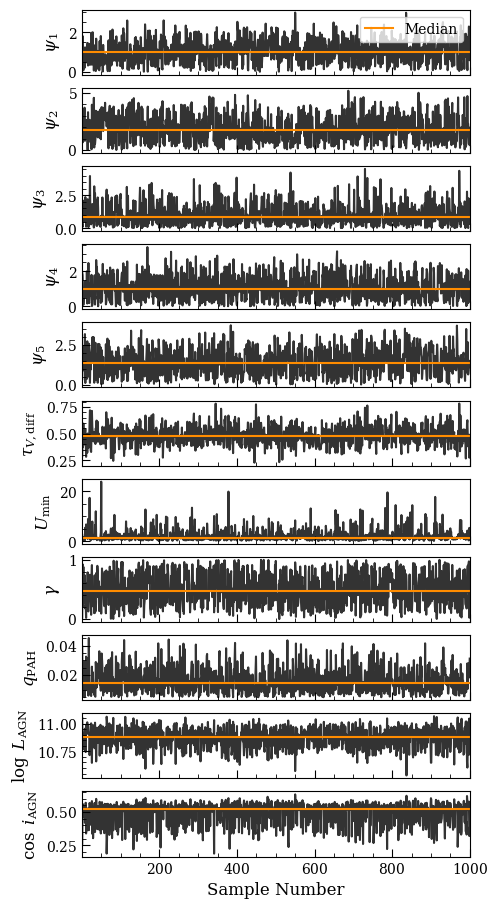

In [29]:
from lightning.plots import chain_plot

fig, axs = chain_plot(l, param_arr, color='k', alpha=0.8)

### Corner Plot
And now a corner plot for the whole set of parameters:

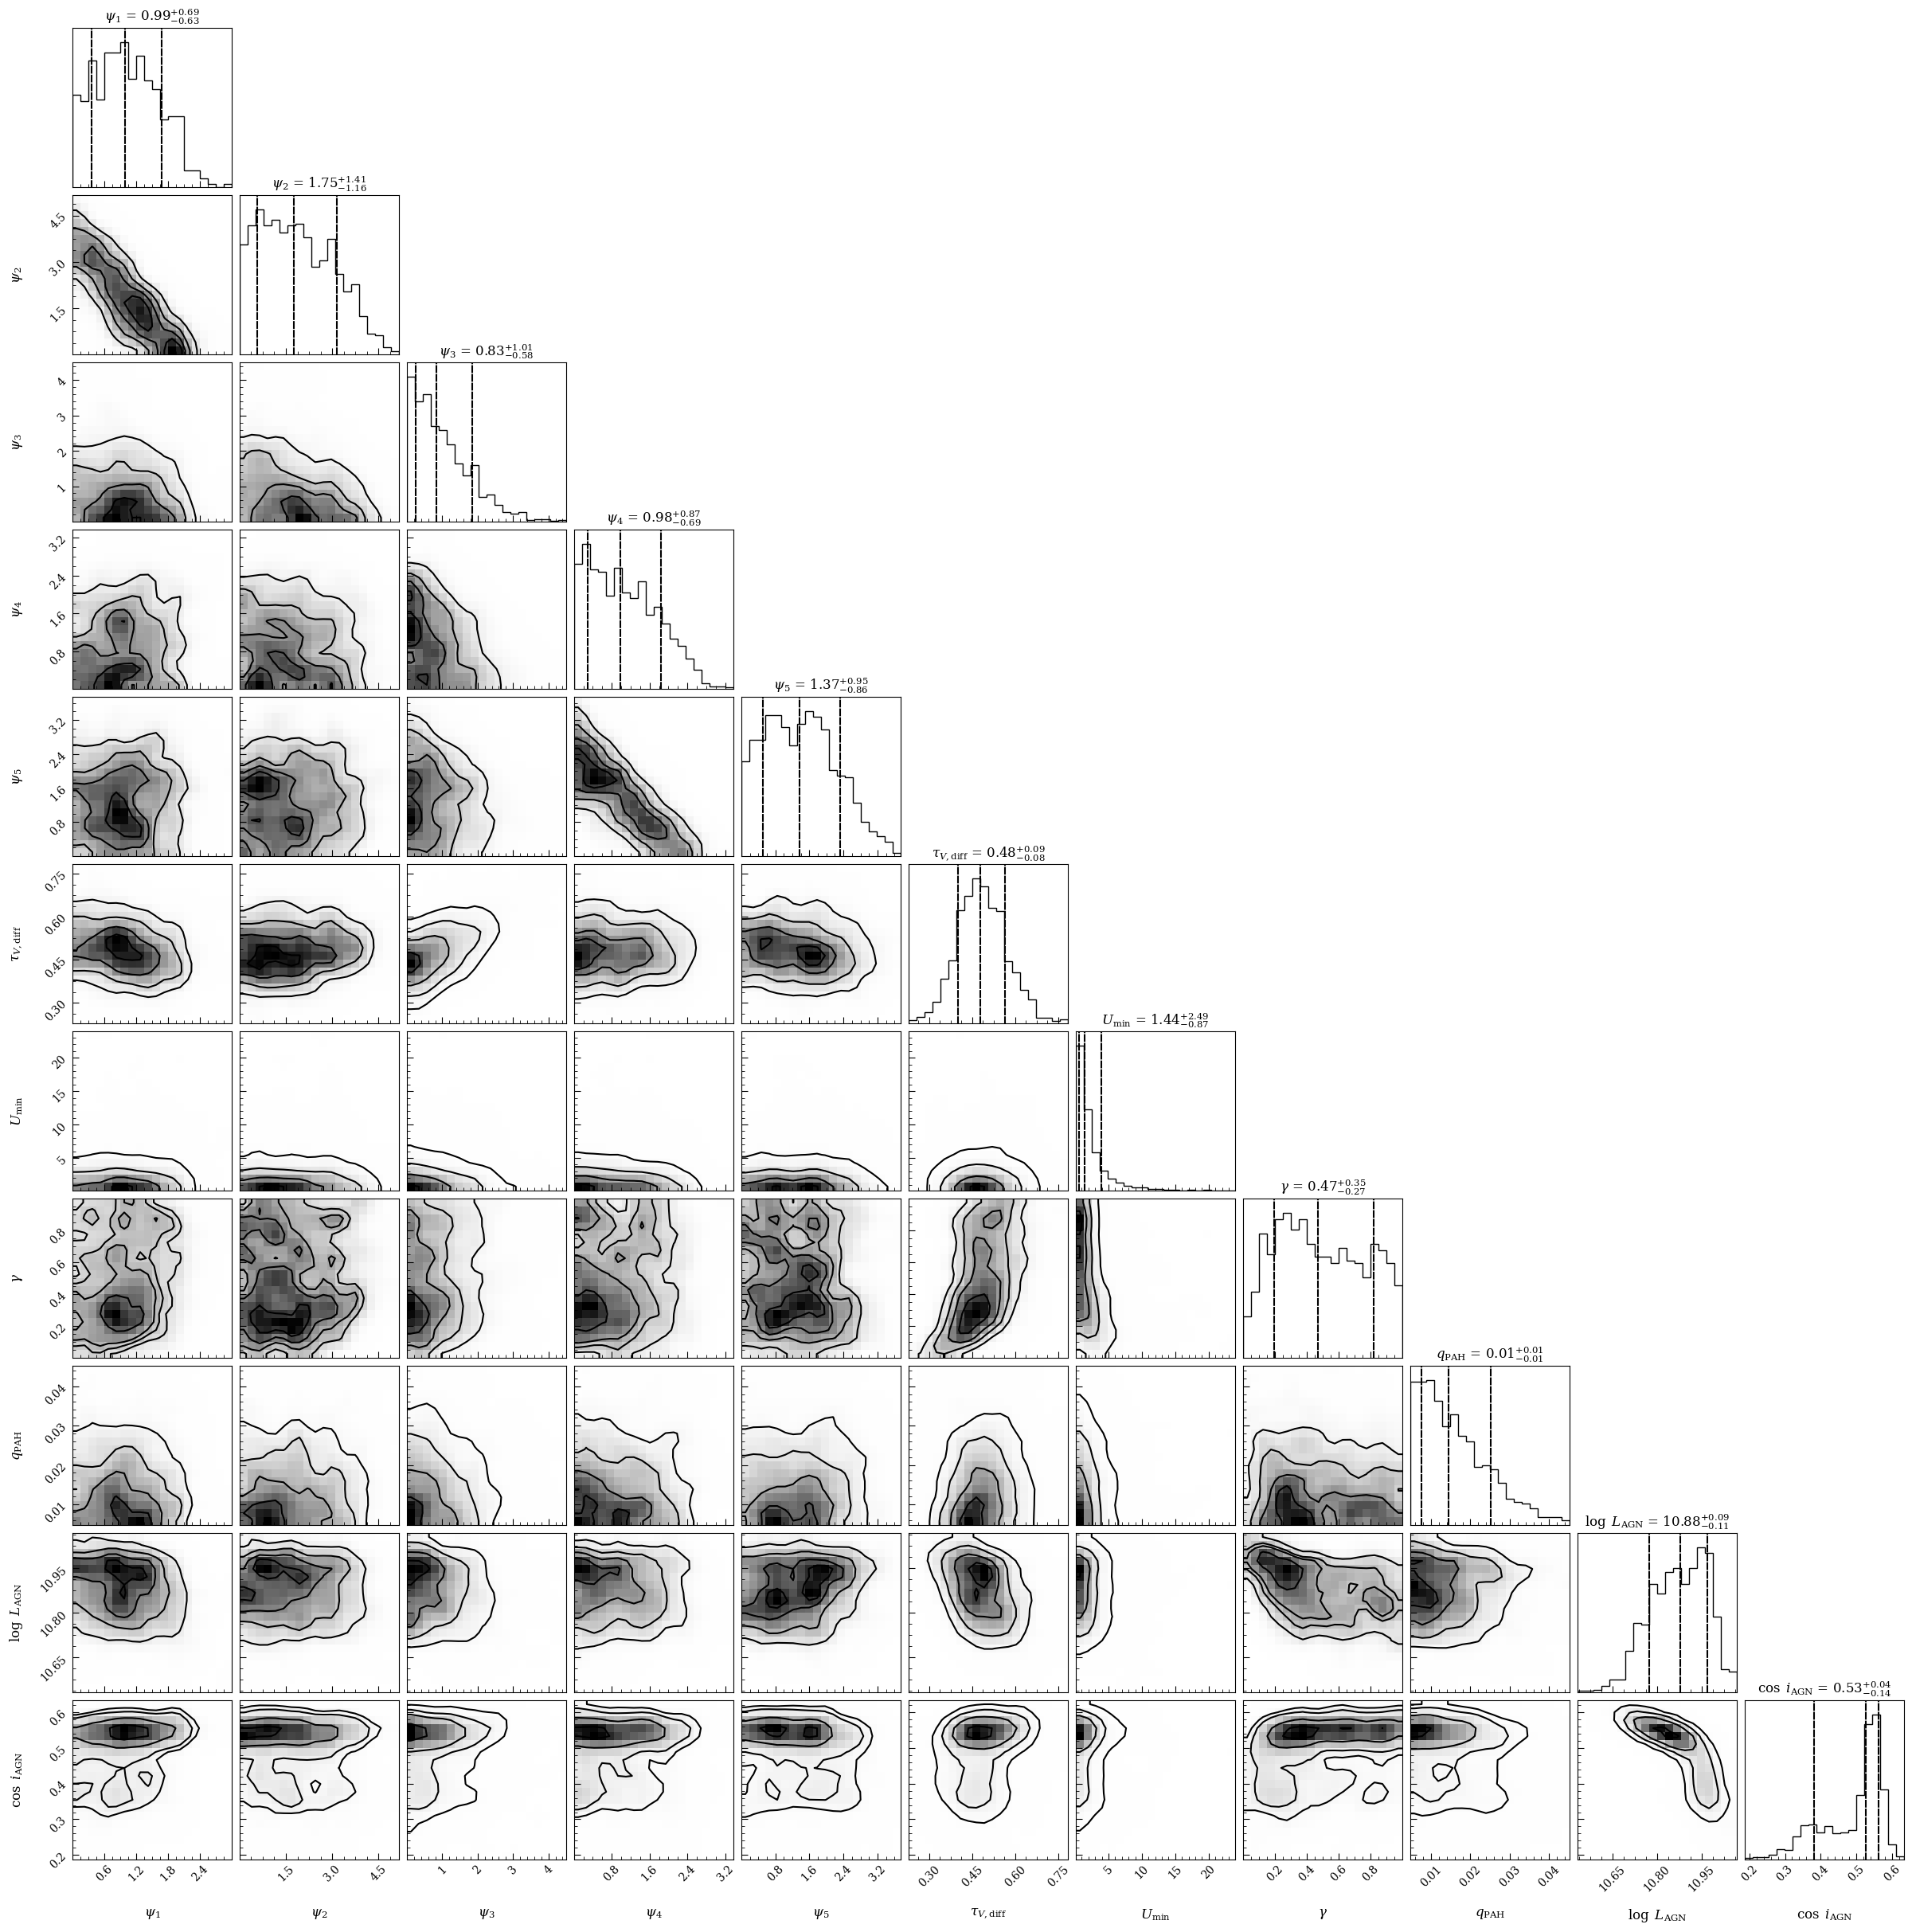

In [31]:
from lightning.plots import corner_plot

fig = corner_plot(l, param_arr, 
                  quantiles=(0.16, 0.50, 0.84),
                  smooth=1,
                  levels=None,
                  show_titles=True)

Sick.

### Best fit SED/Sampled SFH plot
This'll be our typical plot, with the best-fit SED and the 16th-84th percentile of the SFH. In the future this first block would be handled by a helper method of the `Lightning` class that ingests the fitting
result (MCMC sampler from `emcee`, optimization result from `scipy.optimize`, maybe `MultiNest`, who knows).

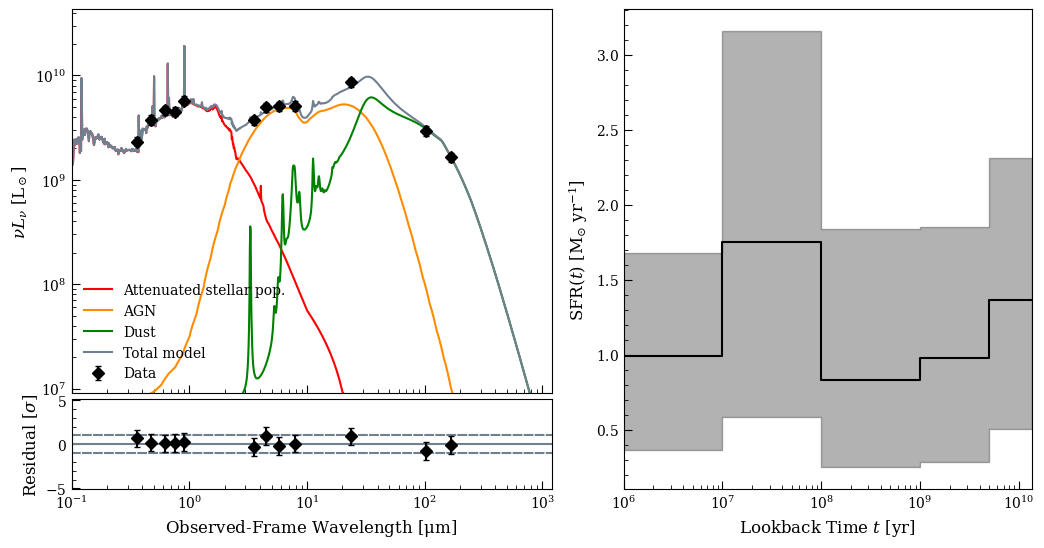

In [33]:
from lightning.plots import sed_plot_bestfit, sed_plot_delchi, sfh_plot

# We can use the builtin plotting functions to make individual figures...
# fig1, ax1 = sed_plot_bestfit(l, param_arr, logprob_chain, plot_components=True)
# fig2, ax2 = sed_plot_delchi(l, param_arr, logprob_chain)
# fig3, ax3 = sfh_plot(l, param_arr)

# Or we can use them to make a complex (hopefully) publication quality 
# figure by laying out our axes and then using the `ax` keyword in each function:
fig4 = plt.figure(figsize=(12,6))
ax41 = fig4.add_axes([0.1, 0.26, 0.4, 0.64])
ax42 = fig4.add_axes([0.1, 0.1, 0.4, 0.15])
ax43 = fig4.add_axes([0.56, 0.1, 0.34, 0.8])

fig4, ax41 = sed_plot_bestfit(l, param_arr, logprob_chain,
                              plot_components=True,
                              ax=ax41,
                              legend_kwargs={'loc': 'lower left', 'frameon': False})
ax41.set_xticklabels([])
fig4, ax42 = sed_plot_delchi(l, param_arr, logprob_chain, ax=ax42)
fig4, ax43 = sfh_plot(l, param_arr, ax=ax43)

Radical.